In [1]:
import utils
import Simple_CNN

import matplotlib.pyplot as plt

import torch
import torchsummary
from torchvision import transforms
import torchaudio


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

from torch.utils.data import DataLoader

from sklearn.preprocessing import OneHotEncoder


import numpy as np
from importlib import reload

import yaml

In [2]:
with open("FlattenCNN.yaml", "r") as f:
  net_archi = yaml.load(f, Loader=yaml.FullLoader)
  
  print(net_archi)

{'FlattenCNN': {'input_shape': [3, 1024, 256], 'conv_channels': [8, 16, 32, 32, 64, 64], 'conv_kernel_size': [2, 2, 2, 2, 2, 2], 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_dropout': [0.4, 0.3, 0.3, 0.2, 0.2, 0.2], 'linear_features': [6, 128, 232], 'linear_dropout': [0.4, 0.4], 'last_layer_activation': 'Softmax(dim=1)'}}


In [3]:
# Parameters
random_seed = 42

batch_size = 16
lr = 0.001
epochs = 150

net_name = "FlattenCNN"

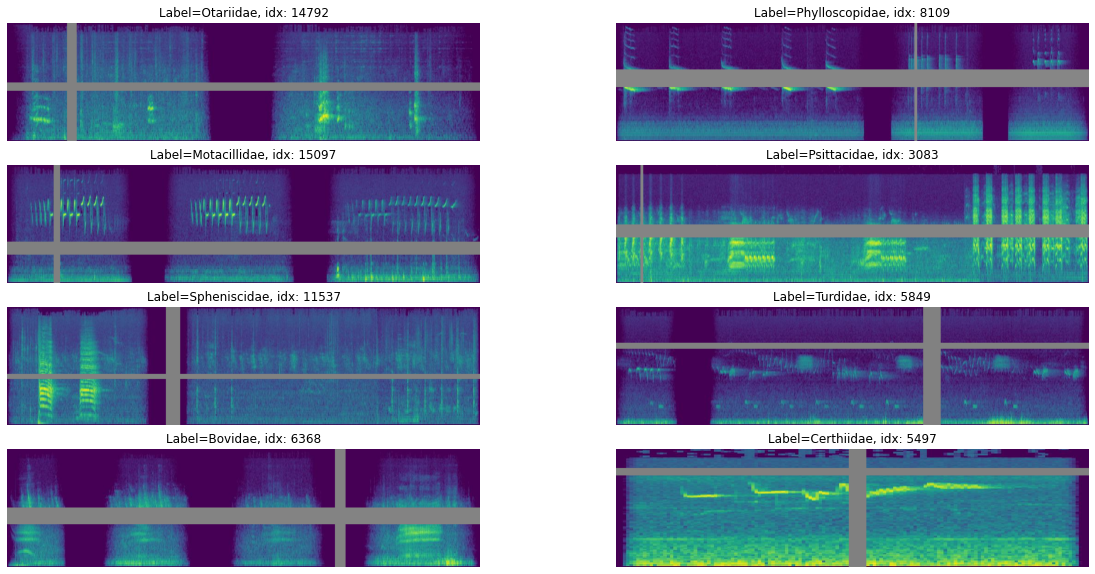

In [4]:
reload(utils)

transform_img = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
     torchaudio.transforms.FrequencyMasking(freq_mask_param=40),
     torchaudio.transforms.TimeMasking(time_mask_param=40),
    ]
)

transform_labels = transforms.Compose(
    [transforms.ToTensor()]
)

dataset = utils.SpectrogramDataset("../datasets/full_dataset_df.csv", 
                                   "../spectrograms/full_dataset", 
                                   "gbifID", "family", 
                                   transform=transform_img, 
                                   one_hot_encode_labels=True)
dataset.show_sample(8, figsize=(20, 10))

In [5]:
dataset.csv.head()

,Unnamed: 0,gbifID,identifier,species,genus,family,class,phylum,file_name
0,0,1572324720,http://www.tierstimmenarchiv.de/recordings/Cre...,Crex crex,Crex,Rallidae,Aves,Chordata,Chordata/Aves/Rallidae/Crex/Crex_crex/15723247...
1,1,1572324719,http://www.tierstimmenarchiv.de/recordings/Cre...,Crex crex,Crex,Rallidae,Aves,Chordata,Chordata/Aves/Rallidae/Crex/Crex_crex/15723247...
2,2,1572324718,http://www.tierstimmenarchiv.de/recordings/Cre...,Crex crex,Crex,Rallidae,Aves,Chordata,Chordata/Aves/Rallidae/Crex/Crex_crex/15723247...
3,3,1572324717,http://www.tierstimmenarchiv.de/recordings/Cre...,Crex crex,Crex,Rallidae,Aves,Chordata,Chordata/Aves/Rallidae/Crex/Crex_crex/15723247...
4,4,1572324716,http://www.tierstimmenarchiv.de/recordings/Cre...,Crex crex,Crex,Rallidae,Aves,Chordata,Chordata/Aves/Rallidae/Crex/Crex_crex/15723247...


In [6]:
test_percentage = .2
test_len = int((len(dataset) * test_percentage))
train_len = len(dataset) - test_len

train, test = random_split(dataset, [train_len, test_len], torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [7]:
len(train_loader.dataset), len(test_loader.dataset)

(12935, 3233)

In [8]:
net_archi[net_name]

{'input_shape': [3, 1024, 256],
 'conv_channels': [8, 16, 32, 32, 64, 64],
 'conv_kernel_size': [2, 2, 2, 2, 2, 2],
 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]],
 'conv_dropout': [0.4, 0.3, 0.3, 0.2, 0.2, 0.2],
 'linear_features': [6, 128, 232],
 'linear_dropout': [0.4, 0.4],
 'last_layer_activation': 'Softmax(dim=1)'}

In [9]:
reload(Simple_CNN)
net = Simple_CNN.SimpleCNN(net_archi[net_name])

net = utils.cuda_network(net)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = lr)

torchsummary.summary(net, (3, 1024, 256))

CUDA available: converting network to CUDA
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 8, 1024, 256]             104
       BatchNorm2d-2         [-1, 8, 1024, 256]              16
         MaxPool2d-3          [-1, 8, 512, 128]               0
              ReLU-4          [-1, 8, 512, 128]               0
           Dropout-5          [-1, 8, 512, 128]               0
            Conv2d-6         [-1, 16, 512, 128]             528
       BatchNorm2d-7         [-1, 16, 512, 128]              32
         MaxPool2d-8          [-1, 16, 256, 64]               0
              ReLU-9          [-1, 16, 256, 64]               0
          Dropout-10          [-1, 16, 256, 64]               0
           Conv2d-11          [-1, 32, 256, 64]           2,080
      BatchNorm2d-12          [-1, 32, 256, 64]              64
        MaxPool2d-13          [-1, 32, 128, 32]             

In [10]:
net.parameters

<bound method Module.parameters of SimpleCNN(
  (conv): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (3): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (5): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm2d(64, e

Training FlattenCNN:  12%|██▏               | 18/150 [36:53<4:30:30, 122.96s/it]


KeyboardInterrupt: 

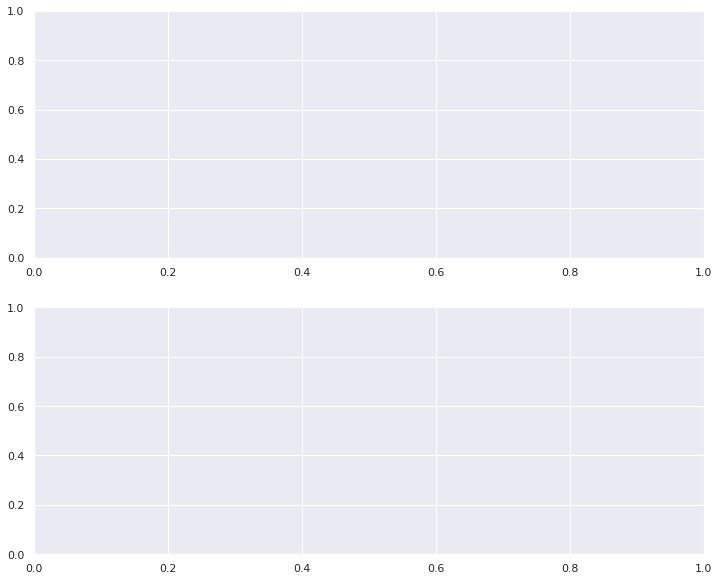

In [11]:
torch.cuda.empty_cache()
((train_loss, train_acc),
 (val_loss, val_acc)) = net.fit(epochs, train_loader, test_loader, criterion, optimizer,
                             log_file="CNN_out/" + net_name+".log", 
                             plot_file="CNN_out/" + net_name+".png", 
                             train_name=net_name)

In [ ]:
print("Train set:")
print(f"\tLoss: \t\t{train_loss:.2f}")
print(f"\tAccuracy: \t{train_acc:.2f}")

print("Validation set:")
print(f"\tLoss: \t\t{val_loss:.2f}")
print(f"\tAccuracy: \t{val_acc:.2f}")

In [ ]:
torch.save(net, "CNN_out/" + net_name+".pth")

In [ ]:
model = torch.load("CNN_out/" + net_name+".pth")
model.eval()